In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf
from keras.utils import np_utils


from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import robust_scale

def simpleAccuracy(pred, dummy_y):
    pred_Y = np.argmax(pred, axis=1)
    true_Y = np.argmax(dummy_y, axis=1)
    
    # this gives the measure of correctly tagged events, over the total
    return sum(pred_Y == true_Y)/len(true_Y)

In [3]:


variables = [
    ## best results with all variables, but should get pruned at some point...
    #'n_jet',
    #'n_central',
    #'n_fwd',
    'n_tau',
    'n_track',
    'st',
    #'ht',
    'met',
    'mjj_max',
    'delta_eta_jj',
    'lead_lep_pt',
    'lead_lep_eta',
    'sublead_lep_pt',
    'sublead_lep_eta',
    'dilepton_mass',
    'dilepton_pt',
    'fwd_jet_pt',
    'fwd_jet_p',
    'fwd_jet_eta',
    'lead_jet_pt',
    'sublead_jet_pt',
    'lead_jet_eta',
    'sublead_jet_eta',
    'lead_btag_pt',
    'sublead_btag_pt',
    'lead_btag_eta',
    'sublead_btag_eta',
    ##'weight', # this does of course _not_ work 🤡 
]

In [110]:
## filter some data
df = pd.read_hdf('data/multiclass_input.h5') # load data processed with ML_processor.py

df_MG = pd.read_hdf('data/multiclass_input_loose_MG.h5')

preselection = ((df['n_jet']>2) & (df['n_btag']>0) & (df['n_lep_tight']==2))
#preselection = ((df['n_jet']>2) & (df['n_btag']>0)) # redundant selection, but we can filter on top


df = df[preselection]
df_MG = df_MG[preselection]

## cranking up stats by a mere 70% is not really worth it...
#frames = [df, df_MG]
#df_train = pd.concat(frames)

# maybe less overtraining??
df_train = df

labels = df['label'].values
labels_train = df_train['label'].values

X = df_train[(labels_train<5)][variables]
labels_train = labels_train[labels_train<5]

labels = labels[labels<5]

In [111]:
df

,mjj_max,delta_eta_jj,met,ht,st,n_jet,n_btag,n_fwd,n_central,n_tau,...,lead_lep_phi,lead_lep_charge,sublead_lep_pt,sublead_lep_eta,sublead_lep_phi,sublead_lep_charge,dilepton_mass,dilepton_pt,label,weight
0,194.105621,1.260254,74.373802,262.125000,430.023193,4.0,1.0,1.0,4.0,1.0,...,-2.675293,-1.0,40.998814,-1.281250,1.844971,-1.0,107.509613,60.145172,5.0,0.000040
1,354.433075,2.412842,70.159790,349.093750,523.315552,4.0,1.0,1.0,3.0,1.0,...,-1.113037,-1.0,31.747696,2.341797,-0.483154,-1.0,32.560280,99.738411,5.0,0.000056
2,290.271454,2.643188,70.001572,323.656250,451.389374,4.0,1.0,1.0,4.0,1.0,...,0.045479,-1.0,28.273561,-0.105957,1.872803,-1.0,50.063515,35.277813,5.0,0.000086
3,157.515152,1.109863,41.140411,201.015625,323.658203,4.0,1.0,1.0,4.0,1.0,...,-2.823242,1.0,30.392860,1.449463,-2.618164,1.0,18.275454,81.101807,5.0,0.000043
4,426.071411,4.686035,6.460495,228.312500,358.505798,5.0,1.0,1.0,4.0,2.0,...,0.084686,-1.0,43.126644,-1.731445,-2.075195,-1.0,106.548592,67.040459,5.0,0.000174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299269,199.571579,0.890991,57.686241,814.937500,1475.260498,4.0,1.0,1.0,4.0,2.0,...,1.627930,1.0,249.277435,-1.074707,0.324280,1.0,412.415558,483.225861,2.0,0.000042
299270,1022.480896,6.838867,182.823135,383.406250,901.623779,7.0,1.0,1.0,4.0,2.0,...,2.117188,1.0,41.437054,1.258301,-0.856567,1.0,420.602661,253.197189,2.0,0.000052
299271,545.401672,3.413574,55.045460,673.671875,853.150330,6.0,1.0,1.0,5.0,2.0,...,0.515747,-1.0,55.729889,0.167572,-1.882568,-1.0,154.267349,46.775703,2.0,0.000036
299272,665.844177,3.913315,67.131966,599.437500,832.836914,9.0,1.0,4.0,5.0,1.0,...,0.363159,1.0,56.715988,0.622681,-0.901367,1.0,111.110977,137.713120,2.0,0.000050


In [112]:
df['lead_lep_pt'].values

array([ 52.52557755,  72.31430817,  29.45798683, ...,  68.70306396,
       109.55143738, 168.31530762])

In [118]:
def delta_phi(phi1, phi2):
    return np.arccos(np.cos(phi1 - phi2))

def delta_r2(eta1, eta2, phi1, phi2):
    return (eta1 - eta2) ** 2 + delta_phi(phi1, phi2) ** 2

def delta_r(eta1, eta2, phi1, phi2):
    return np.sqrt(delta_r2(eta1, eta2, phi1, phi2))

In [120]:
combinations = [
    ['lead_lep', 'lead_btag'],
    ['lead_lep', 'sublead_btag'],
    ['sublead_lep', 'lead_btag'],
    ['sublead_lep', 'sublead_btag'],
]

In [119]:
delta_r(df['lead_lep_eta'], df['lead_btag_eta'], df['lead_lep_phi'], df['lead_btag_phi'])

0         1.259133
1         2.234293
2         2.023602
3         1.171399
4         2.326457
            ...   
299269    2.697708
299270    2.685974
299271    2.528175
299272    2.880294
299273    2.715711
Length: 299274, dtype: float64

In [113]:
from Tools.objects import delta_r

In [ ]:
delta_r()

In [6]:
encoder = LabelEncoder()
encoder.fit(labels_train)
dummy_y = np_utils.to_categorical(labels_train)

dummy_y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [7]:
robust = False

if not robust:
    X_mean, X_std = X.mean(), X.std()

    X_norm = copy.deepcopy(X)
    X_norm -= X_mean
    X_norm /= X_std

else:
    X_norm = robust_scale(X, quantile_range=(10.0, 90.0))

X_norm = np.nan_to_num(X_norm, 0) # this happens in like 10 events
X_norm

array([[-0.7634506 , -0.37761877, -0.67296494, ..., -0.54580037,
         0.65490174,  1.56692216],
       [ 0.60907918, -0.37761877, -1.299501  , ..., -0.52862014,
         1.7734658 ,  1.66022541],
       [-0.7634506 , -0.37761877,  0.05253223, ..., -0.62352043,
        -0.83291913,  0.60676657],
       ...,
       [ 0.60907918, -0.37761877,  0.34348393, ..., -0.52657488,
        -0.64762796,  1.39351553],
       [-0.7634506 , -0.37761877,  0.27613494, ..., -0.63824634,
         0.86509407,  0.25565882],
       [ 0.60907918, -0.37761877, -0.21758168, ..., -0.16333583,
        -1.08893718, -1.26671217]])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, dummy_y, train_size= int( 0.9*dummy_y.shape[0] ), random_state=42 )

In [9]:
from sklearn.utils import compute_class_weight

y_train_int = np.argmax(y_train, axis=1) # back to integers from one hot
y_test_int = np.argmax(y_test, axis=1) # back to integers from one hot

classWeight = compute_class_weight('balanced', classes=np.unique(y_train_int, axis=0), y=y_train_int) 
classWeight = dict(enumerate(classWeight))
classWeight

{0: 0.475249959633848,
 1: 1.0104787809966462,
 2: 0.8119294671844166,
 3: 1.5771082351001566,
 4: 24.68632258064516}

In [10]:
input_dim = len(variables)
out_dim = len(dummy_y[0])

# define baseline model
def baseline_model():
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(54, input_dim=input_dim, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization() )
    model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    #model.add(tf.keras.layers.Dense(54, activation='relu'))
    #model.add(tf.keras.layers.Dense(100, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization() )
    #model.add( tf.keras.layers.Dropout( rate = 0.3 ) )
    model.add(tf.keras.layers.Dense(out_dim, activation='softmax'))
    
    #opt = tf.keras.optimizers.SGD(lr=0.1)
    #opt = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    #opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    opt = tf.keras.optimizers.RMSprop(lr=0.001) ## performs best.
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=['accuracy'],
    )
    return model
 

model = baseline_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 54)                1296      
_________________________________________________________________
batch_normalization (BatchNo (None, 54)                216       
_________________________________________________________________
dropout (Dropout)            (None, 54)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 275       
Total params: 1,787
Trainable params: 1,679
Non-trainable params: 108
_________________________________________________________________


In [11]:
from ML.lrcurve import KerasLearningCurve

epochs = 50
batch_size = 5120
#batch_size = 1000
validation_split = 0.2

history = model.fit(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_split = validation_split,
    verbose = 0,
    class_weight = classWeight,
    callbacks = [KerasLearningCurve()]
)

In [12]:

if not robust:
    X_all = df[variables].values
    X_all -= X_mean
    X_all /= X_std
else:
    X_all = robust_scale(df[variables].values, quantile_range=(10.0, 90.0))
    
pred_all = model.predict( X_all )
pred_train = model.predict( X_train )
pred_test = model.predict( X_test )
pred_all[:,0]

array([0.08198605, 0.12788752, 0.09466478, ..., 0.19844384, 0.4088746 ,
       0.20224269], dtype=float32)

In [13]:
df['score_topW'] = pred_all[:,0]
df['score_ttW'] = pred_all[:,1]
df['score_ttZ'] = pred_all[:,2]
df['score_ttH'] = pred_all[:,3]
df['score_ttbar'] = pred_all[:,4]
df['score_best'] = np.argmax(pred_all, axis=1)

In [41]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from coffea import processor, hist
from processor.std_acumulators import *

from plots.helpers import *

score_axis              = hist.Bin("score",          r"N", 20, 0, 1)
#score_axis_v2           = hist.Bin("score",          r"N", 5, 0.15, 0.65)
score_axis_v2           = hist.Bin("score",          r"N", 4, 0.2, 0.6)
p_axis                  = hist.Bin("p",             r"$p$ (GeV)", 10, 0, 3500)

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
#p_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
score_bins_coarse = hist.Bin('score', 'score', 10, 0, 1)
eta_bins = hist.Bin('eta', r'$\eta $', 50, -5.0, 5.0)

In [89]:
processes = {
    'topW_v2': df[df['label']==0],
    'TTW': df[df['label']==1],
    'TTZ': df[df['label']==2],
    'TTH': df[df['label']==3],
    'ttbar': df[df['label']==4],
    'rare': df[df['label']==5],
}

sel_SR = ((df['n_jet']>0) & (df['n_central']>0) & (df['n_lep_tight']==2))

sel_topW = ((df['score_best']==0) & (df['n_lep_tight']==2))
sel_baseline = ((df['n_jet']>4) & (df['n_central']>3) & (df['met']>50) & (df['st']>600))

sel_topW_pos = (sel_topW & (df['lead_lep_charge']>0))
sel_topW_neg = (sel_topW & (df['lead_lep_charge']<0))

sel_ttW = ((df['score_best']==1))
sel_ttZ = ((df['score_best']==2))
sel_ttH = ((df['score_best']==3))
sel_ttbar = ((df['score_best']==4))

h_best_score = hist.Hist("best_score", dataset_axis, multiplicity_axis)
h_score_topW = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_Run3 = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_pos = hist.Hist("score", dataset_axis, score_axis_v2)
h_score_topW_neg = hist.Hist("score", dataset_axis, score_axis_v2)
h_score = hist.Hist("score", dataset_axis, score_axis)
h_jet_pt = hist.Hist("jet_pt", dataset_axis, pt_axis)
h_fwd_p = hist.Hist("fwd_p", dataset_axis, p_axis)


for proc in processes:
    h_best_score.fill(dataset=proc, multiplicity=processes[proc][sel_SR]['score_best'].values, weight=processes[proc][sel_SR]['weight'].values*137)
    h_score_topW.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*137)
    h_score_topW_Run3.fill(dataset=proc, score=processes[proc][sel_topW]["score_topW"].values, weight=processes[proc][sel_topW]["weight"].values*300)
    h_score_topW_pos.fill(dataset=proc, score=processes[proc][sel_topW_pos]["score_topW"].values, weight=processes[proc][sel_topW_pos]["weight"].values*137)
    h_score_topW_neg.fill(dataset=proc, score=processes[proc][sel_topW_neg]["score_topW"].values, weight=processes[proc][sel_topW_neg]["weight"].values*137)
    
    h_score.fill(dataset=proc, score=processes[proc][sel_SR]["score_topW"].values, weight=processes[proc][sel_SR]["weight"].values*137)
    h_jet_pt.fill(dataset=proc, pt=processes[proc][sel_topW]["lead_jet_pt"].values, weight=processes[proc][sel_topW]["weight"].values*137)
    h_fwd_p.fill(dataset=proc, p=processes[proc][sel_baseline]["fwd_jet_p"].values, weight=processes[proc][sel_baseline]["weight"].values*137)

In [90]:
output = {
    'best_score': h_best_score,
    'score_topW': h_score_topW,
    'score_topW_Run3': h_score_topW_Run3,
    'score_topW_pos': h_score_topW_Run2_pos,
    'score_topW_neg': h_score_topW_Run2_neg,
    'score': h_score,
    'jet_pt': h_jet_pt,
    'fwd_p': h_fwd_p,
}

Data: 0 MC: 922.06


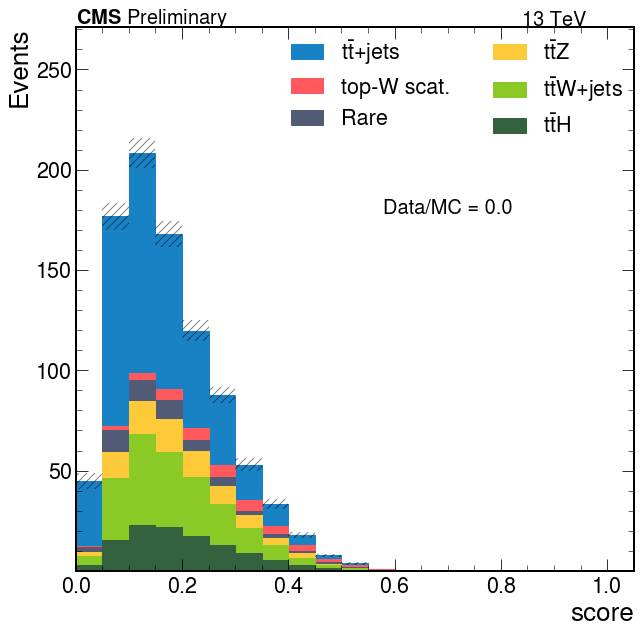

In [91]:
makePlot(output, 'score', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label='score',
        )

Data: 0 MC: 68.24


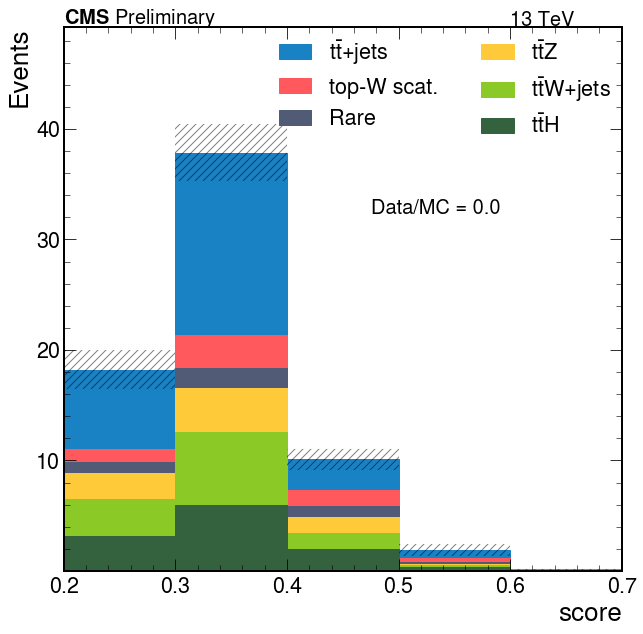

In [93]:
makePlot(output, 'score_topW_neg', 'score',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label='score',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

Data: 0 MC: 155.54


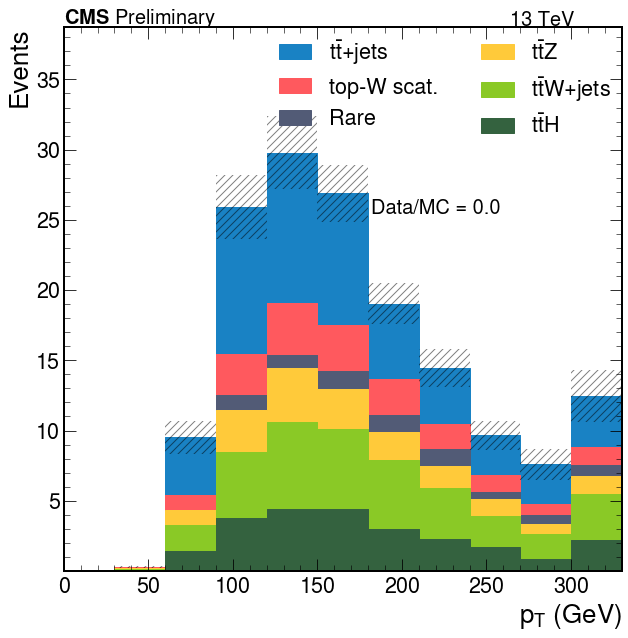

In [94]:
makePlot(output, 'jet_pt', 'pt',
         data_sel=None, # use None if you don't use observation
         bins=pt_bins_coarse, log=False, normalize=True, axis_label=r'$p_T\ (GeV)$',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

Data: 0 MC: 284.68


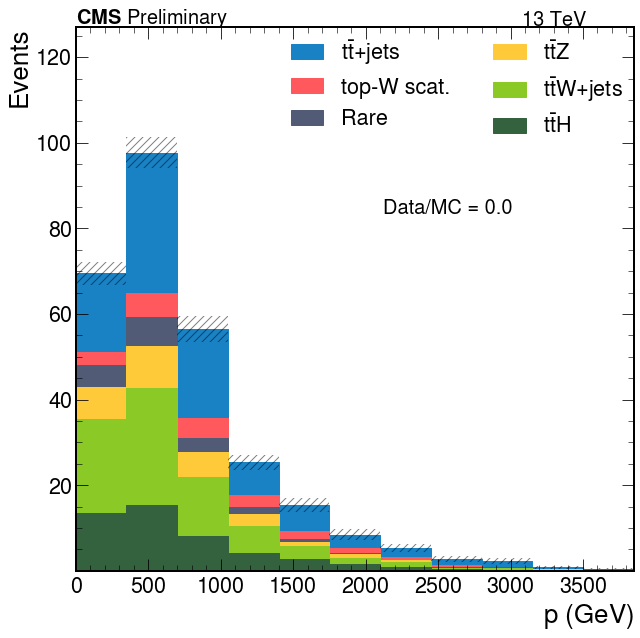

In [95]:
makePlot(output, 'fwd_p', 'p',
         data_sel=None, # use None if you don't use observation
         bins=None, log=False, normalize=True, axis_label=r'$p\ (GeV)$',
         #shape=True, ymax=0.4,
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier_score_topW'
        )

In [96]:
n_topW = h_score_topW['topW_v2'].sum('score', overflow='over').sum('dataset', overflow='over').values(overflow='over')[()]
n_all = h_score_topW.sum('score', overflow='over').sum('dataset', overflow='over').values(overflow='over')[()]

n_topW/(n_all-n_topW)

0.1363055597132231

In [97]:
h_score_topW.sum('score', overflow='over').values(overflow='over')

{('topW_v2',): 18.65810893865833,
 ('TTW',): 34.42902434878524,
 ('TTZ',): 17.472412581267026,
 ('TTH',): 24.10521467020832,
 ('ttbar',): 53.296707000110146,
 ('rare',): 7.5810720707891335}

In [98]:
df[((df['label']==0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>0.35))]['weight'].sum()*60

4.483215483882394

In [99]:
df[((df['label']>0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>0.35))]['weight'].sum()*60

23.20288350004431

In [80]:
def get_S_over_B(cut):
    sig = df[((df['label']==0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>cut))]['weight'].sum()*60
    bkg = df[((df['label']>0) & (df['score_best']==0) & (df['n_lep_tight']==2) & (df['score_topW']>cut))]['weight'].sum()*60
    print ("Cut: %.2f, Signal: %.2f, Background %.2f --> S/B: %.2f"%(cut,sig,bkg,sig/bkg))
    return sig/bkg

In [81]:
get_S_over_B(0.35)

Cut: 0.35, Signal: 4.48, Background 23.20 --> S/B: 0.19


0.19321803188271114

In [82]:
for x in range(100):
    get_S_over_B(x/100)

Cut: 0.00, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.01, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.02, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.03, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.04, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.05, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.06, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.07, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.08, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.09, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.10, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.11, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.12, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.13, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.14, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.15, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.16, Signal: 8.17, Background 59.95 --> S/B: 0.14
Cut: 0.17, Signal: 8.17, Background 59.95 --> S/

In [83]:
df[((df['label']==0))]['weight'].sum()*137

39.0326904504304

In [84]:
df[((df['label']>0))]['weight'].sum()*137

883.031798856567

Data: 0 MC: 922.06


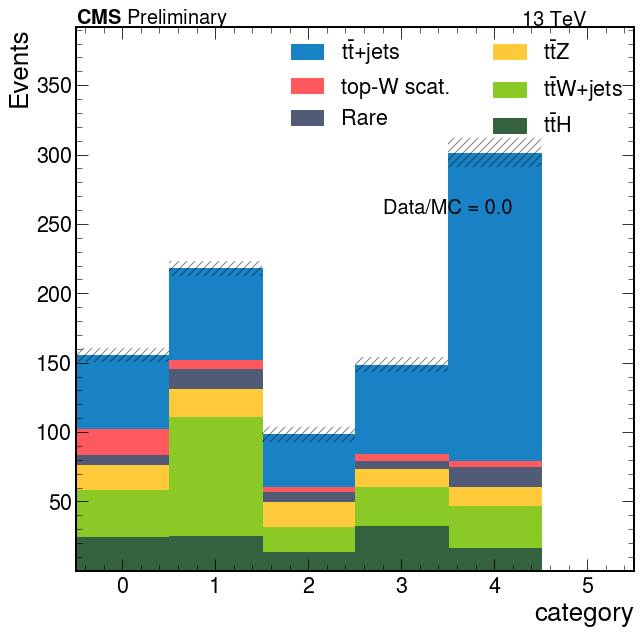

In [85]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='category',
         #save='/home/users/dspitzba/public_html/tW_scattering/dump/multiclassifier'
        )

Data: 0 MC: 922.06


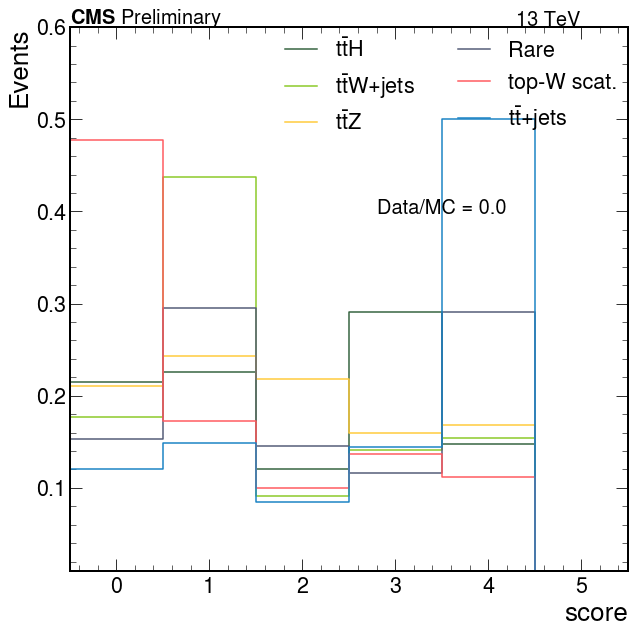

In [86]:
makePlot(output, 'best_score', 'multiplicity',
         data_sel=None, # use None if you don't use observation
         bins=N_bins_red, log=False, normalize=True, axis_label='score', shape=True, ymax=0.6,
        )

In [106]:
from Tools.dataCard import dataCard
from Tools.limits import makeCardFromHist

SR_card = makeCardFromHist(output, 'score_topW', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_Run3 = makeCardFromHist(output, 'score_topW_Run3', nonprompt_scale=0.5, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_pos = makeCardFromHist(output, 'score_topW_pos', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_neg = makeCardFromHist(output, 'score_topW_neg', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)

SR_card_BL = makeCardFromHist(output, 'fwd_p', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='', systematics=True)
SR_card_stat = makeCardFromHist(output, 'score_topW', nonprompt_scale=1, signal_scale=1, bkg_scale=1, overflow='all', ext='_stat', systematics=False)

Writing cards using histogram: score_topW
Signal expectation:           18.66
Non-prompt background:        53.30
t(t)X(X)/rare background:     83.59
Observation:                  155.54
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/score_topW_card.txt
Writing cards using histogram: score_topW_Run3
Signal expectation:           40.86
Non-prompt background:        58.35
t(t)X(X)/rare background:     183.04
Observation:                  282.25
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/score_topW_Run3_card.txt
Writing cards using histogram: score_topW_pos
Signal expectation:           12.58
Non-prompt background:        26.15
t(t)X(X)/rare background:     48.57
Observation:                  87.30
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Wr

In [107]:
card = dataCard()

In [108]:
results = card.nllScan(SR_card, rmin=0, rmax=3, npoints=61)
results_Run3 = card.nllScan(SR_card_Run3, rmin=0, rmax=3, npoints=61)
results_stat = card.nllScan(SR_card_stat, rmin=0, rmax=3, npoints=61)
results_BL = card.nllScan(SR_card_BL, rmin=0, rmax=3, npoints=61)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/bbc40c51-6bb2-4f8f-a198-9ee5e22e25fd
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/f28f89dc-ce81-4085-89d6-d165b79dd760
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/ecb5ebbb-9de1-43e8-912c-f89f149e4ee9
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/bb890cdb-7232-4bd2-9a62-1ce62374f907


In [103]:
SR_card_opt = card.combineCards({'pos': SR_card_pos, 'neg':SR_card_neg})
results_opt = card.nllScan(SR_card_opt, rmin=0, rmax=3, npoints=61)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/d2a14573-7abe-4b45-9225-cc105f381e48
Copying card file to temp: score_topW_pos_card.txt
Copying card file to temp: score_topW_neg_card.txt
 dc_pos=score_topW_pos_card.txt dc_neg=score_topW_neg_card.txt
Executing cd /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/d2a14573-7abe-4b45-9225-cc105f381e48; eval `scramv1 runtime -sh`; combineCards.py  dc_pos=score_topW_pos_card.txt dc_neg=score_topW_neg_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/ML/b8c03221-8c6c-43f2-a23b-329a57be0d93


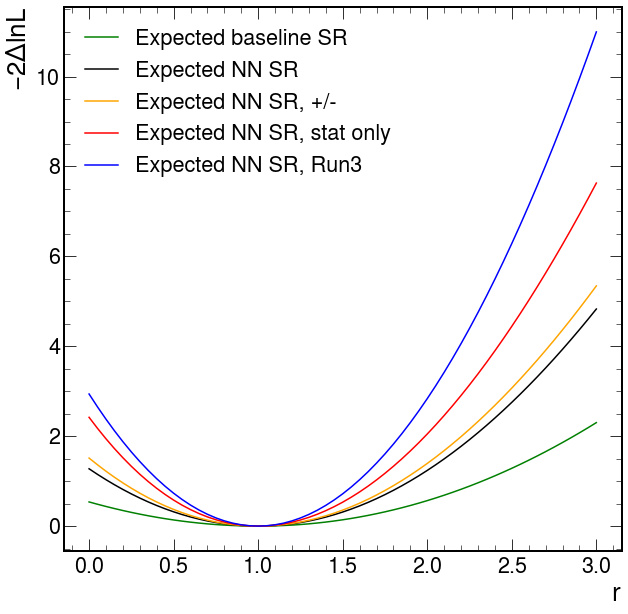

In [109]:
import mplhep
plt.style.use(mplhep.style.CMS)

plt.figure()

plt.plot(results_BL['r'][1:], results_BL['deltaNLL'][1:]*2, label=r'Expected baseline SR', c='green')
plt.plot(results['r'][1:], results['deltaNLL'][1:]*2, label=r'Expected NN SR', c='black')
plt.plot(results_opt['r'][1:], results_opt['deltaNLL'][1:]*2, label=r'Expected NN SR, +/-', c='orange')
plt.plot(results_stat['r'][1:], results_stat['deltaNLL'][1:]*2, label=r'Expected NN SR, stat only', c='red')
plt.plot(results_Run3['r'][1:], results_Run3['deltaNLL'][1:]*2, label=r'Expected NN SR, Run3', c='blue')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [105]:
card.cleanUp()

Deleting:  d2a14573-7abe-4b45-9225-cc105f381e48


# Stats

In [67]:
import scipy
from yahist import Hist1D


In [68]:
colors = ['gray', 'blue', 'red', 'green', 'orange']

bins = [x/20 for x in range(21)]

def test_train(test, train, y_test, y_train, labels=[], bins=25, node=0):
    h = {}
    for i, label in enumerate(labels):
        
        _ks, _p = scipy.stats.kstest(
            train[:,node][(y_train==i)],
            test[:,node][(y_test==i)]
        )
        
        h[label+'_test'] = Hist1D(test[:,node][(y_test==i)], bins=bins).normalize()
        h[label+'_train'] = Hist1D(train[:,node][(y_train==i)], bins=bins, label=label+' (p=%.2f, KS=%.2f)'%(_p, _ks)).normalize()
        

        h[label+'_test'].plot(color=colors[i], histtype="step", ls='--', linewidth=2)
        h[label+'_train'].plot(color=colors[i], histtype="step", linewidth=2)
        
def test_train_cat(test, train, y_test, y_train, labels=[], n_cat=5):
    bins = [x-0.5 for x in range(n_cat+1)]
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    
    h = {}
    for i, label in enumerate(labels):
        
        _ks, _p = scipy.stats.kstest(
            np.argmax(train, axis=1)[(y_train==i)],
            np.argmax(test, axis=1)[(y_test==i)]
        )
        
        h[label+'_test'] = Hist1D(np.argmax(test, axis=1)[(y_test==i)], bins=bins).normalize()
        h[label+'_train'] = Hist1D(np.argmax(train, axis=1)[(y_train==i)], bins=bins, label=label+' (p=%.2f, KS=%.2f)'%(_p, _ks)).normalize()
        

        h[label+'_test'].plot(color=colors[i], histtype="step", ls='--', linewidth=2)
        h[label+'_train'].plot(color=colors[i], histtype="step", linewidth=2)
        
    ax.set_ylabel('a.u.')
    ax.set_xlabel('category')

    ax.set_ylim(0,1/n_cat*5)

    
def get_ROC(test, train, y_test, y_train, node=0):

    y_test_binary = (y_test!=node)*0 + (y_test==node)*1

    fpr_test, tpr_test, thresholds_test = roc_curve( y_test_binary, test[:,node] )
    auc_val_test = auc(fpr_test, tpr_test)

    plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))

    y_train_binary = (y_train!=node)*0 + (y_train==node)*1
    
    fpr_train, tpr_train, thresholds_test = roc_curve( y_train_binary, train[:,node]  )
    auc_val_train = auc(fpr_train, tpr_train)

    plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))

    plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
    plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
    plt.legend(loc ='lower left')

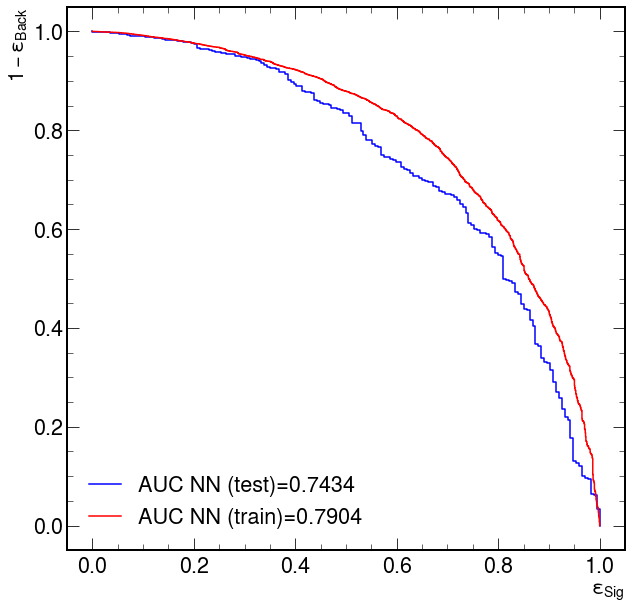

In [69]:
get_ROC(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    node=4,
)

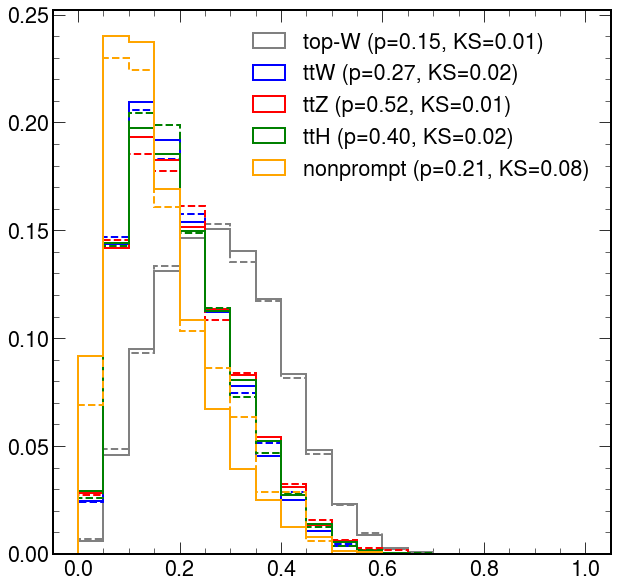

In [235]:
test_train(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    labels=['top-W', 'ttW', 'ttZ', 'ttH', 'nonprompt'],
    node=0,
    bins=bins,
)

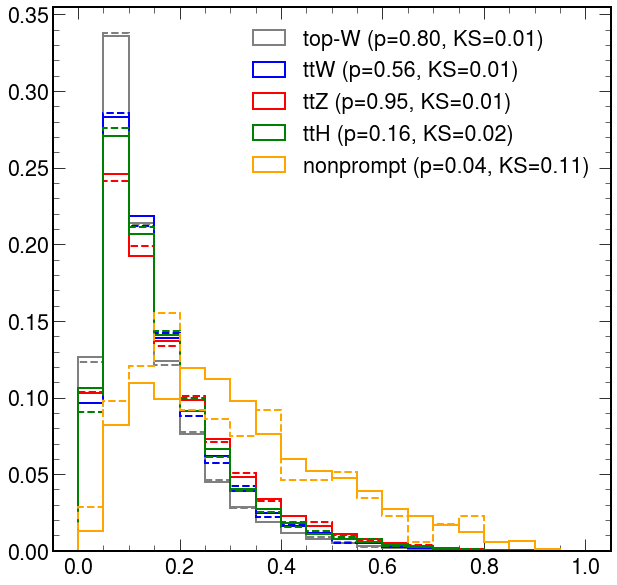

In [236]:
test_train(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    labels=['top-W', 'ttW', 'ttZ', 'ttH', 'nonprompt'],
    node=4,
    bins=bins,
)

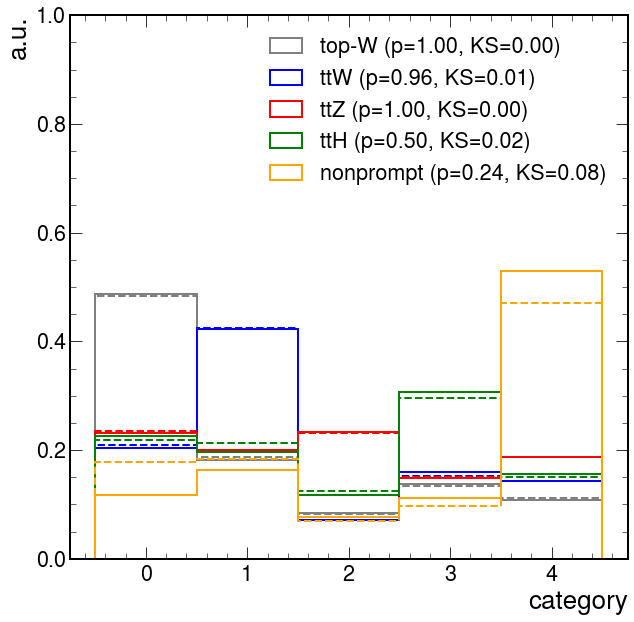

In [237]:
test_train_cat(
    pred_test,
    pred_train,
    y_test_int,
    y_train_int,
    labels=['top-W', 'ttW', 'ttZ', 'ttH', 'nonprompt'],
    n_cat=5,
)